### Load Libraries

In [1110]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

### Read in cleaned dataframe

In [1111]:
nyc_copy = pd.read_csv('nyc_copy.csv')
nyc_copy.shape

(38511, 16)

In [1112]:
nyc_copy.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,4.342945e-10,0.954243,2018-10-19,-0.677781,7.781513e-01,2.562293
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,4.342945e-10,1.653213,2019-05-21,-0.420216,3.010300e-01,2.550228
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,4.342945e-10,2.431364,2019-07-05,0.666518,4.342945e-10,2.287802
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,1.000000e+00,0.954243,2018-11-19,-1.000000,4.342945e-10,-9.000000
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,4.771213e-01,1.869232,2019-06-22,-0.229148,4.342945e-10,2.110590


### Perform Regression

### Gather variables of interest

In [1113]:
nyc_price = nyc_copy.loc[(nyc_copy['price'] <= 300)]
nyc_price.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,3.634800e+04,3.634800e+04,36348.000000,36348.000000,36348.000000,3.634800e+04,3.634800e+04,36348.000000,3.634800e+04,36348.000000
mean,1.805229e+07,6.326013e+07,40.727738,-73.949700,116.839936,4.442812e-01,1.008281e+00,-0.232308,2.118440e-01,-1.714470
std,1.062056e+07,7.475896e+07,0.055807,0.047113,64.341327,4.076286e-01,6.672914e-01,0.655760,3.919938e-01,5.212203
min,2.539000e+03,2.571000e+03,40.506410,-74.244420,10.000000,4.342945e-10,4.342945e-10,-2.000000,4.342945e-10,-9.000000
25%,8.755084e+06,7.093221e+06,40.687960,-73.981192,65.000000,4.342945e-10,4.771213e-01,-0.721246,4.342945e-10,-9.000000
50%,1.881532e+07,2.815071e+07,40.720580,-73.953620,100.000000,3.010300e-01,1.000000e+00,-0.136677,4.342945e-10,1.690196
75%,2.742939e+07,9.939225e+07,40.763350,-73.933018,150.000000,6.020600e-01,1.531479e+00,0.307496,3.010300e-01,2.340444
max,3.645581e+07,2.738417e+08,40.913060,-73.712990,300.000000,1.491362e+00,2.798651e+00,1.767156,2.514548e+00,2.562293


In [1114]:
# Trim to data of interest
vars_interest = pd.DataFrame(nyc_price, columns = ['price','minimum_nights', 'number_of_reviews',
                                  'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 
                                 'room_type', 'neighbourhood_group', 'neighbourhood'] )

# Convert to dummy variables 
# Get dummy variables for categorical data:
# neighbourhood may get removed since it's 200+ variables
vars_final = pd.get_dummies(vars_interest, columns= ['room_type','neighbourhood_group', 'neighbourhood'], drop_first = True)

In [1115]:
df = nyc_price._get_numeric_data() # drop non-numeric columns

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif["features"] = df.columns
vif.round(1)

,VIF Factor,features
0,5.3,id
1,2.7,host_id
2,0.8,latitude
3,413338.2,longitude
4,1.0,price
5,1.2,minimum_nights
6,9.1,number_of_reviews
7,10.4,reviews_per_month
8,1.2,calculated_host_listings_count
9,1.6,availability_365


In [1116]:
# Prepare for regression
# Gather predictors 
X = vars_final.drop('price', axis=1)
X

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Private room,room_type_Shared room,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,...,neighbourhood_Westchester Square,neighbourhood_Westerleigh,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodside
0,4.342945e-10,9.542425e-01,-6.777807e-01,7.781513e-01,2.562293e+00,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.342945e-10,1.653213e+00,-4.202164e-01,3.010300e-01,2.550228e+00,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,4.342945e-10,2.431364e+00,6.665180e-01,4.342945e-10,2.287802e+00,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.000000e+00,9.542425e-01,-1.000000e+00,4.342945e-10,-9.000000e+00,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4.771213e-01,1.869232e+00,-2.291480e-01,4.342945e-10,2.110590e+00,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38506,4.342945e-10,4.342945e-10,4.342945e-10,4.342945e-10,2.167317e+00,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
38507,4.342945e-10,4.342945e-10,4.342945e-10,7.781513e-01,2.530200e+00,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
38508,4.342945e-10,4.342945e-10,4.342945e-10,4.342945e-10,1.939519e+00,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38509,4.342945e-10,3.010300e-01,3.010300e-01,4.342945e-10,1.602060e+00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1117]:
# Gather predicted variable (price) and log transform it
y = pd.DataFrame(nyc_price, columns = ['price'])
y = np.log10(y['price'])

In [1118]:
# Standardize variables
standardized_X = preprocessing.scale(X)

### Perform Regression

In [1119]:
# Perform regression, get r square
regressor = LinearRegression()  
regressor.fit(standardized_X, y)

r_sq = regressor.score(standardized_X, y)
print('coefficient of determination:', round(r_sq,2))

coefficient of determination: 0.62


In [1120]:
# To retrieve the intercept:
# print(regressor.intercept_)

# For retrieving the slope:
# print(regressor.coef_)

In [1121]:
# Predict
y_pred = regressor.predict(standardized_X)

In [1122]:
# View Coefficients
regressor.coef_
coeff_df = pd.DataFrame(X.columns, regressor.coef_)  
coeff_df = coeff_df.reset_index()
coeff_df.rename(columns={'index':'Coefficient',0:'Variable'}, inplace=True)
coeff_df

,Coefficient,Variable
0,-2.623792e-02,minimum_nights
1,-3.884135e-03,number_of_reviews
2,-6.358396e-03,reviews_per_month
3,-4.966295e-03,calculated_host_listings_count
4,3.389447e-02,availability_365
...,...,...
223,1.137153e+08,neighbourhood_Willowbrook
224,1.205158e+06,neighbourhood_Windsor Terrace
225,1.498454e+08,neighbourhood_Woodhaven
226,-1.366287e-03,neighbourhood_Woodlawn


In [1123]:
df = pd.DataFrame({'Actual': np.round(10 ** y, 0), 
                   'Predicted': np.round(10 ** y_pred, 0)})
df.head(10)

,Actual,Predicted
0,149.0,62.0
1,225.0,222.0
2,89.0,163.0
3,80.0,124.0
4,200.0,200.0
5,79.0,106.0
6,79.0,82.0
7,150.0,189.0
8,135.0,175.0
9,85.0,106.0


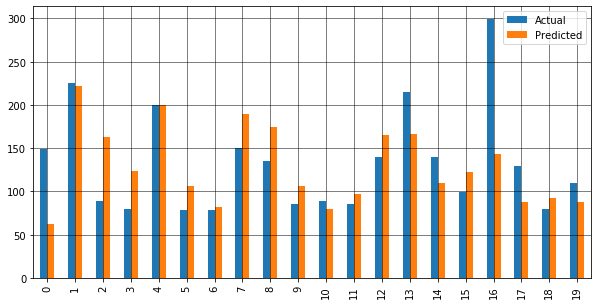

In [1124]:
# Plot actual vs predicted values on subset of data
# Can modify df1 size to view more towers
df1 = df.head(20)
df1.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [1125]:
# Print out model metrics
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y, y_pred),2)) 
print('Mean Squared Error:', round(metrics.mean_squared_error(y, y_pred),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y, y_pred)),2))
print('Mean Average Percent Error:', round(np.mean(np.abs(y - y_pred)/np.abs(y)),2))

Mean Absolute Error: 0.12
Mean Squared Error: 0.02
Root Mean Squared Error: 0.15
Mean Average Percent Error: 0.06


### Split into train and test sets

In [1126]:
X_train, X_test, y_train, y_test = train_test_split(standardized_X, y, test_size=0.2, random_state=0)

In [1127]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) # training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1128]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
minimum_nights,-2.626136e-02
number_of_reviews,-3.437629e-03
reviews_per_month,-6.805664e-03
calculated_host_listings_count,-4.896547e-03
availability_365,3.289116e-02
...,...
neighbourhood_Willowbrook,2.800645e+10
neighbourhood_Windsor Terrace,3.141751e+10
neighbourhood_Woodhaven,4.945722e+10
neighbourhood_Woodlawn,-1.144409e-04


In [1129]:
y_pred = regressor.predict(X_test)

In [1130]:
df = pd.DataFrame({'Actual': np.round(10 ** y_test, 0), 
                   'Predicted': np.round(10 ** y_pred, 0)})
df.head()

,Actual,Predicted
13307,90.0,79.0
22943,110.0,83.0
1141,69.0,106.0
23638,79.0,78.0
32084,32.0,29.0


In [1131]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred),2))  
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred),2))  
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),2))

Mean Absolute Error: 0.12
Mean Squared Error: 0.02
Root Mean Squared Error: 0.15


In [1132]:
print('Price mean:', np.round(np.mean(10**y), 2))  
print('Price std:', np.round(np.std(10**y), 2))
print('RMSE:', np.round(np.sqrt(metrics.mean_squared_error(10**y_test, 10**regressor.predict(X_test))), 2))
print('R2 score train:', np.round(r2_score(y_train, regressor.predict(X_train), multioutput='variance_weighted'), 2))
print('R2 score test:', np.round(r2_score(y_test, regressor.predict(X_test), multioutput='variance_weighted'), 2))

Price mean: 116.84
Price std: 64.34
RMSE: 44.15
R2 score train: 0.61
R2 score test: 0.62


### Lets split the data into a low and high price point and predict price on those two separate datasets

In [1133]:
"""
From our exploratory analysis we saw that most of the listings are actually < $300 a night, however the few
that are much higher contribute to large variance and likely lower the predicition accuracy of the model. For this
reason I would like to try to run the model on two data sets - the > $300 and the < $300 one. 
"""

'\nFrom our exploratory analysis we saw that most of the listings are actually < $300 a night, however the few\nthat are much higher contribute to large variance and likely lower the predicition accuracy of the model. For this\nreason I would like to try to run the model on two data sets - the > $300 and the < $300 one. \n'

In [1260]:
# Filter the dataset into two groups: low price and high price 
# Set the high range to be >= 175 and the low range to be < 175

nyc_low = nyc_price[(nyc_price['price'] < 175)]
nyc_high = nyc_price[(nyc_price['price'] >= 175)]

In [1219]:
print("There are " + str(len(nyc_low)) + " listings below $175")
print("There are " + str(len(nyc_high)) + " listings at or above $175")

There are 29112 listings below $175
There are 7236 listings at or above $175


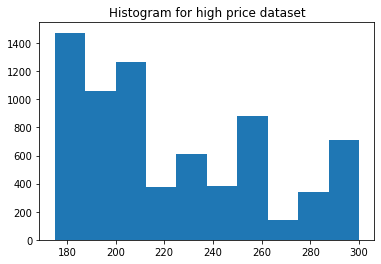

In [1136]:
plt.hist(nyc_high['price'])
plt.title("Histogram for high price dataset")
plt.show()

In [1137]:
print(nyc_low.shape)

(29112, 16)


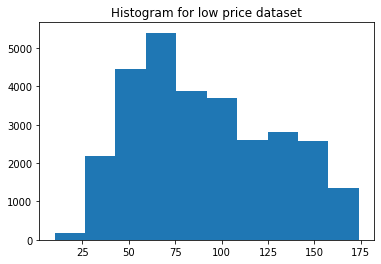

In [1138]:
plt.hist(nyc_low['price'])
plt.title("Histogram for low price dataset")
plt.show()

### Lets do the low price dataset first

In [1139]:
# Trim to data of interest
vars_interest_low = pd.DataFrame(nyc_low, columns = ['price','minimum_nights', 'number_of_reviews',
                                  'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 
                                 'room_type', 'neighbourhood_group', 'neighbourhood'] )

# Convert to dummy variables 
# Get dummy variables for categorical data:
# neighbourhood may get removed since it's 200+ variables
vars_final_low = pd.get_dummies(vars_interest_low, columns= ['room_type','neighbourhood_group', 'neighbourhood'], drop_first = True)

In [1140]:
# Prepare for regression
# Gather predictors 
X_low = vars_final_low.drop('price', axis=1)

In [1141]:
# Standardize
standardized_X_low = preprocessing.scale(X_low)

In [1142]:
# Gather predicted variable (price) and log transform it
y_low = pd.DataFrame(nyc_low, columns = ['price'])
y_low = np.log10(y_low['price'])

In [1143]:
# Perform regression, get r square
regressor = LinearRegression()  
regressor.fit(standardized_X_low, y_low)

r_sq = regressor.score(standardized_X_low, y_low)
print('coefficient of determination:', round(r_sq,2))

coefficient of determination: 0.55


In [1144]:
# Predict
y_pred_low = regressor.predict(standardized_X_low)

In [1145]:
# Print out model metrics
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_low, y_pred_low),2))  
print('Mean Squared Error:', round(metrics.mean_squared_error(y_low, y_pred_low),2))  
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_low, y_pred_low)),2))
print('Mean Average Percent Error:', round(np.mean(np.abs(y_low - y_pred_low)/np.abs(y_low)),2)) 

Mean Absolute Error: 0.1
Mean Squared Error: 0.02
Root Mean Squared Error: 0.13
Mean Average Percent Error: 0.05


In [1146]:
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(standardized_X_low, y_low, test_size=0.3, random_state=0)

In [1147]:
regressor = LinearRegression()  
regressor.fit(X_train_low, y_train_low) # training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1148]:
y_pred = regressor.predict(X_test_low)

In [1149]:
df = pd.DataFrame({'Actual': np.round(10** y_test_low,0), 'Predicted': np.round(10**y_pred,0)})
df['Difference'] = df['Actual'] - df['Predicted']
df.sort_values(by = 'Predicted')

,Actual,Predicted,Difference
35919,85.0,0.0,85.0
9953,79.0,0.0,79.0
9227,80.0,0.0,80.0
24900,60.0,0.0,60.0
35424,25.0,27.0,-2.0
...,...,...,...
10992,150.0,178.0,-28.0
31762,114.0,178.0,-64.0
5266,125.0,178.0,-53.0
4895,140.0,181.0,-41.0


In [1150]:
print('Price mean:', np.round(np.mean(10**y_low), 2))  
print('Price std:', np.round(np.std(10**y_low), 2))
print('RMSE:', np.round(np.sqrt(metrics.mean_squared_error(10**y_test_low, 10 ** regressor.predict(X_test_low))), 2))
print('R2 score train:', np.round(r2_score(10**y_train_low, 10 ** regressor.predict(X_train_low), multioutput='variance_weighted'), 2))
print('R2 score test:', np.round(r2_score(10**y_test_low, 10 ** regressor.predict(X_test_low), multioutput='variance_weighted'), 2))

Price mean: 90.82
Price std: 37.47
RMSE: 26.17
R2 score train: 0.52
R2 score test: 0.52


### Now for the high price dataset

In [1261]:
# Trim to data of interest
vars_interest_high = pd.DataFrame(nyc_high, columns = ['price','minimum_nights', 'number_of_reviews',
                                  'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 
                                 'room_type', 'neighbourhood_group', 'neighbourhood'] )

# Convert to dummy variables 
# Get dummy variables for categorical data:
# neighbourhood may get removed since it's 200+ variables
vars_final_high = pd.get_dummies(vars_interest_high, columns= ['room_type','neighbourhood_group', 'neighbourhood'], drop_first = True)

In [1263]:
vars_final_high.head()
vars_final_high['price'].describe()

count    7236.000000
mean      221.535240
std        38.227844
min       175.000000
25%       190.000000
50%       206.000000
75%       250.000000
max       300.000000
Name: price, dtype: float64

In [1264]:
# Prepare for regression
# Gather predictors 
X_high = vars_final_high.drop('price', axis=1)
X_high.describe()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Private room,room_type_Shared room,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,...,neighbourhood_Wakefield,neighbourhood_Washington Heights,neighbourhood_West Village,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodside
count,7.236000e+03,7.236000e+03,7236.000000,7.236000e+03,7236.000000,7236.000000,7236.000000,7236.000000,7236.000000,7236.000000,...,7236.000000,7236.000000,7236.000000,7236.000000,7236.000000,7236.000000,7236.000000,7236.000000,7236.000000,7236.000000
mean,4.890458e-01,9.656182e-01,-0.251879,2.193238e-01,-1.283303,0.075318,0.002211,0.309011,0.632808,0.050166,...,0.000138,0.004837,0.042841,0.000138,0.000415,0.092040,0.000138,0.002764,0.000138,0.001797
std,3.926317e-01,6.535919e-01,0.637248,5.268071e-01,5.063768,0.263922,0.046974,0.462117,0.482073,0.218302,...,0.011756,0.069384,0.202513,0.011756,0.020359,0.289102,0.011756,0.052504,0.011756,0.042351
min,4.342945e-10,4.342945e-10,-2.000000,4.342945e-10,-9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.010300e-01,4.771213e-01,-0.721246,4.342945e-10,-9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.771213e-01,9.030900e-01,-0.167491,4.342945e-10,1.832509,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.020600e-01,1.462398e+00,0.285557,3.010300e-01,2.394452,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.491362e+00,2.606381e+00,1.446382,2.514548e+00,2.562293,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [1265]:
# Standardize variables 
standardized_X_high =  preprocessing.scale(X_high)

In [1289]:
# Gather predicted variable (price) and log transform it
y_high = pd.DataFrame(nyc_high, columns = ['price'])
y_high = np.log10(y_high['price'])

In [1290]:
# Perform regression, get r square
regressor = LinearRegression()  
regressor.fit(standardized_X_high, y_high)

r_sq = regressor.score(standardized_X_high, y_high)
print('coefficient of determination:', round(r_sq,2))

coefficient of determination: 0.05


In [1291]:
# Predict
y_pred_high = regressor.predict(standardized_X_high)
y_pred_high

array([2.35262068, 2.32595595, 2.32252272, ..., 2.36396559, 2.33378663,
       2.31526246])

In [1293]:
# Print out model metrics
print('Mean Absolute Error:', round(metrics.mean_absolute_error(10**y_high, 10**y_pred_high),2))  
print('Mean Squared Error:', round(metrics.mean_squared_error(10**y_high,10** y_pred_high),2))  
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(10**y_high, 10**y_pred_high)),2))
# print('Mean Average Percent Error:', round(np.mean(np.abs(10**y_high- 10**y_pred_high/np.abs(10**y_high)),2)))

Mean Absolute Error: 30.93
Mean Squared Error: 1395.4
Root Mean Squared Error: 37.36


In [1294]:
X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(standardized_X_high, y_high, test_size=0.2, random_state=0)

In [1295]:
regressor = LinearRegression()  
regressor.fit(X_train_high, y_train_high) # training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1296]:
y_pred = regressor.predict(X_test_high) 
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.describe()

,0
count,1.448000e+03
mean,4.825924e+10
std,2.391414e+12
min,-3.092459e+13
25%,2.330635e+00
50%,2.339973e+00
75%,2.348595e+00
max,7.045683e+13


In [1297]:
x_df = pd.DataFrame(X_test_high)

In [1298]:
y_test_high

37790    2.352183
17769    2.397940
24302    2.243038
31178    2.301030
6499     2.397940
           ...   
7041     2.278754
21494    2.397940
762      2.320146
32519    2.397940
9818     2.243038
Name: price, Length: 1448, dtype: float64

In [1299]:
x = pd.DataFrame(X_test_high)
x['Prediction']= np.round(10**y_pred,1)
x['Prediction_log'] = np.round(y_pred,1)
y_inf = x[x['Prediction'] == np.inf]
x.sort_values(by = 'Prediction')

/Users/ajeustis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  


,0,1,2,3,4,5,6,7,8,9,...,164,165,166,167,168,169,170,171,Prediction,Prediction_log
639,-0.478893,0.576553,0.715624,-0.416355,0.583677,-0.285399,-0.047075,-0.668730,-1.312773,4.351308,...,-0.211563,-0.011757,-0.020366,-0.318386,-0.011757,-0.052646,-0.011757,-0.042424,0.0,-9.221849e+12
920,0.287858,-0.556285,-0.037422,-0.416355,0.748201,-0.285399,-0.047075,-0.668730,-1.312773,-0.229816,...,-0.211563,-0.011757,-0.020366,-0.318386,-0.011757,-0.052646,-0.011757,-0.042424,0.0,-7.511779e+12
651,0.534696,0.276200,0.846951,-0.416355,0.679114,-0.285399,-0.047075,-0.668730,-1.312773,4.351308,...,-0.211563,-0.011757,-0.020366,-0.318386,-0.011757,-0.052646,-0.011757,-0.042424,0.0,-3.092459e+13
285,2.516719,-0.408002,-0.402947,-0.416355,0.737662,3.503864,-0.047075,-0.668730,-1.312773,4.351308,...,-0.211563,-0.011757,-0.020366,-0.318386,-0.011757,-0.052646,-0.011757,-0.042424,183.2,2.300000e+00
577,-1.245644,-0.184409,0.069476,0.155108,0.745754,-0.285399,-0.047075,-0.668730,-1.312773,4.351308,...,-0.211563,-0.011757,-0.020366,-0.318386,-0.011757,-0.052646,-0.011757,-0.042424,189.8,2.300000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,-0.478893,-0.184409,-0.012176,-0.416355,0.578020,-0.285399,-0.047075,-0.668730,-1.312773,4.351308,...,-0.211563,-0.011757,-0.020366,-0.318386,-0.011757,-0.052646,-0.011757,-0.042424,281.2,2.400000e+00
1221,0.287858,-0.556285,-1.109109,-0.416355,0.563158,-0.285399,-0.047075,1.495372,-1.312773,-0.229816,...,-0.211563,-0.011757,-0.020366,-0.318386,-0.011757,-0.052646,-0.011757,-0.042424,295.3,2.500000e+00
960,-0.478893,0.322047,1.181628,0.489392,0.748735,-0.285399,-0.047075,-0.668730,-1.312773,-0.229816,...,-0.211563,-0.011757,-0.020366,-0.318386,-0.011757,-0.052646,-0.011757,-0.042424,311.1,2.500000e+00
132,0.287858,0.825544,0.308161,-0.416355,0.748735,-0.285399,-0.047075,1.495372,-1.312773,-0.229816,...,-0.211563,-0.011757,-0.020366,-0.318386,-0.011757,-0.052646,-0.011757,-0.042424,inf,4.708077e+13


In [1300]:
df = pd.DataFrame({'Actual': np.round(10** y_test_high,1), 'Predicted': np.round(10**y_pred,1)})
df['Difference'] = df['Actual'] - df['Predicted']
df.sort_values(by = 'Predicted')

/Users/ajeustis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in power
  """Entry point for launching an IPython kernel.


,Actual,Predicted,Difference
26353,250.0,0.0,250.0
30834,200.0,0.0,200.0
31792,178.0,0.0,178.0
6765,175.0,183.2,-8.2
28628,200.0,189.8,10.2
...,...,...,...
26370,200.0,281.2,-81.2
4014,199.0,295.3,-96.3
33469,247.0,311.1,-64.1
12677,235.0,inf,-inf


In [1302]:
X_train_high

array([[ 0.53469632,  0.05260805,  0.30037165, ..., -0.05264616,
        -0.01175657, -0.04242412],
       [-0.47889342, -1.47750431, -1.64649194, ..., -0.05264616,
        -0.01175657, -0.04242412],
       [-0.03037281, -0.55628487, -0.5228277 , ..., -0.05264616,
        -0.01175657, -0.04242412],
       ...,
       [-0.47889342,  0.63437397, -0.09090521, ..., -0.05264616,
        -0.01175657, -0.04242412],
       [-0.47889342,  1.91951051,  1.41126193, ..., -0.05264616,
        -0.01175657, -0.04242412],
       [ 2.51671898, -1.01689459, -1.52222837, ..., -0.05264616,
        -0.01175657, -0.04242412]])

In [1323]:
print('Price mean:', np.round(np.mean(10**y_high), 2))  
print('Price std:', np.round(np.std(10**y_high), 2))
print('RMSE:', np.round(np.sqrt(metrics.mean_squared_error(y_test_high, regressor.predict(X_test_high))), 2))
print('R2 score train:', np.round(r2_score(y_train_high, regressor.predict(X_train_high), multioutput='variance_weighted'), 2))
print('R2 score test:', np.round(r2_score(y_test_high, regressor.predict(X_test_high), multioutput='variance_weighted'), 2))

Price mean: 221.54
Price std: 38.23
RMSE: 2391075014310.4
R2 score train: 0.05
R2 score test: -1.111333111036452e+27


In [ ]:
# Random Forest Regression

In [1282]:
# Fitting Random Forest Regression to the dataset
rfr = RandomForestRegressor(max_depth=8, n_estimators = 100, random_state = 0)
rfr.fit(X_train_high, y_train_high)

# Predicting the Test set results
y_pred_high = rfr.predict(X_test_high)

In [1283]:
df = pd.DataFrame({'Actual': np.round(10 ** y_test_high, 0), 
                   'Predicted': np.round(10 ** y_pred_high, 0)})
df.head(10)

,Actual,Predicted
37790,225.0,230.0
17769,250.0,227.0
24302,175.0,222.0
31178,200.0,213.0
6499,250.0,210.0
36951,290.0,227.0
1906,225.0,224.0
6019,265.0,219.0
18088,200.0,217.0
33667,175.0,229.0


In [1321]:
print('Price mean:', np.round(np.mean(10**y_high), 2))  
print('Price std:', np.round(np.std(10**y_high), 2))
print('RMSE:', np.round(np.sqrt(metrics.mean_squared_error(10**y_test_high, 10**rfr.predict(X_test_high))), 2))
print('R2 score train:', np.round(r2_score(y_train_high, rfr.predict(X_train_high), multioutput='variance_weighted'), 2))
print('R2 score test:', np.round(r2_score(y_test_high, rfr.predict(X_test_high), multioutput='variance_weighted'), 2))

Price mean: 221.54
Price std: 38.23
RMSE: 37.53
R2 score train: 0.17
R2 score test: 0.03
